#### 6.1, 6.2, 6.3 LSTM

In [1]:
# Matmul - Exploding Gradient 예시
import numpy as np
import matplotlib.pyplot as plt

N=2
H=3
T=20

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H,H)

norm_list=[]
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

Text(0, 0.5, 'norm')

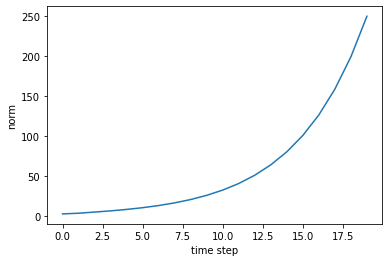

In [4]:
plt.plot(range(T), norm_list)
plt.xlabel('time step')
plt.ylabel('norm')

In [5]:
Wh = np.random.randn(H,H)
print(Wh)
Wh = np.random.randn(H,H)*.5
print(Wh)

[[-0.47721803 -1.31386475  0.88462238]
 [ 0.88131804  1.70957306  0.05003364]
 [-0.40467741 -0.54535995 -1.54647732]]
[[ 0.49118372 -0.55053382 -0.59252326]
 [-0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248]]


Text(0, 0.5, 'norm')

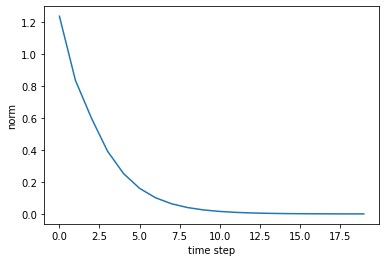

In [6]:
# Matmul - Vanishing Gradient 예시
import numpy as np
import matplotlib.pyplot as plt

N=2
H=3
T=20

dh = np.ones((N,H))
np.random.seed(3)
# Wh = np.random.randn(H,H)
Wh = np.random.randn(H,H)*.5

norm_list=[]
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)
    
plt.plot(range(T), norm_list)
plt.xlabel('time step')
plt.ylabel('norm')

In [ ]:
# Weight Clipping (Exploding gradient 해결방법)
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # threshold

def clip_grads(grads, max_norm):
    total_norm=0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm) # total_norm : ||g||
    
    rate = max_norm/(total_norm + 1e-6)
    if rate<1: # threshold < ||g||
        for grad in grads:
            grad*=rate

In [ ]:
# LSTM, Time LSTM 구현
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None